In [1]:
import os
import pickle
import numpy as np

from spenderq import load_model
from spenderq import util as U
from spenderq import lyalpha as LyA

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
niter = 3
ibatch = 0

# load model
models, losses = load_model('/tigress/chhahn/spender_qso/models/qso.london.z_2p1_3p5.rebin.iter%i.pt' % niter)

# load batch
with open('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.pkl' % (niter, ibatch), "rb") as f:
    spec, w, z, target_id, norm, zerr = pickle.load(f)
    
# load true continuum
true_cont = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz_%i.true_cont.npy' % (ibatch))

# load SpenderQ recon 
w_recon = np.array(models[0].wave_rest.detach().cpu())
recon = np.load('/tigress/chhahn/spender_qso/train/DESIlondon_highz.rebin.iter%i_%i.recons.npy' % (niter, ibatch))

/home/chhahn/projects/SpenderQ/src/spenderq/__init__.py:41: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_struct = torch.load(filename, map_location=device)


In [5]:
picca = U.london_picca('LyA')
picca_lyb = U.london_picca('LyB')

In [13]:
# continuum residual over full wavelength
wave_rest_rebin = np.linspace(800, 3000, 2000)

dcont_recon, dfcont_recon = [], []
dcont_picca, dfcont_picca = [], []
dcont_picca_lyb, dfcont_picca_lyb = [], []

for igal in range(len(z)): 
    wlim = (wave_rest_rebin > 3.6e3/float(1+z[igal])) & ((wave_rest_rebin < 9.9e3/float(1+z[igal])))
    
    # rebin true continuum
    true_rebin = U.trapz_rebin(
        np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
        np.array(true_cont[igal]/norm[igal]), 
        xnew=wave_rest_rebin[wlim])
    
    # rebin reconstruction
    recon_rebin = U.trapz_rebin(
        w_recon, 
        recon[igal], 
        xnew=wave_rest_rebin[wlim])
    
    # residual
    dcont = np.repeat(-999., len(wave_rest_rebin))
    dcont[wlim] = true_rebin - recon_rebin 
    
    # fractional residual
    dfcont = np.repeat(-999., len(wave_rest_rebin))
    dfcont[wlim] = (true_rebin - recon_rebin)/true_rebin

    dcont_recon.append(dcont)
    dfcont_recon.append(dfcont)
    
    
    # picca
    # rebinning for picca
    wlim = (wave_rest_rebin > np.max([1040, 3.6e3/float(1+z[igal])])) & (wave_rest_rebin < 1195)
    
    fpicca = picca.get_continuum(int(target_id[igal]))
    if fpicca is not None: 
        # rebin true continuum
        true_rebin = U.trapz_rebin(
            np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
            np.array(true_cont[igal]/norm[igal]), 
            xnew=wave_rest_rebin[wlim])
        
        # rebin picca
        fpicca /= np.array(norm[igal])
        picca_rebin = U.trapz_rebin(
            picca.wave_picca, 
            fpicca, 
            xnew=wave_rest_rebin[wlim])
        
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dcont[wlim] = true_rebin - picca_rebin 
            
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont[wlim] = (true_rebin - picca_rebin)/true_rebin
    else:
        # no picca
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        
    dcont_picca.append(dcont)
    dfcont_picca.append(dfcont)

    # rebinning for picca LyB
    wlim = (wave_rest_rebin > np.max([920, 3.6e3/float(1+z[igal])])) & (wave_rest_rebin < 1020)
    
    fpicca = picca_lyb.get_continuum(int(target_id[igal]))
    if fpicca is not None: 
        # rebin true continuum
        true_rebin = U.trapz_rebin(
            np.linspace(3.50e3, 1e4, 3251)/float(1 + z[igal]), 
            np.array(true_cont[igal]/norm[igal]), 
            xnew=wave_rest_rebin[wlim])
        
        # rebin picca
        fpicca /= np.array(norm[igal])
        picca_rebin = U.trapz_rebin(
            picca_lyb.wave_picca, 
            fpicca, 
            xnew=wave_rest_rebin[wlim])
        
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dcont[wlim] = true_rebin - picca_rebin 
            
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont[wlim] = (true_rebin - picca_rebin)/true_rebin
    else:
        # no picca
        dcont = np.repeat(-999., len(wave_rest_rebin))
        dfcont = np.repeat(-999., len(wave_rest_rebin))
        
    dcont_picca_lyb.append(dcont)
    dfcont_picca_lyb.append(dfcont)
    
dcont_recon = np.array(dcont_recon)
dfcont_recon = np.array(dfcont_recon)

dcont_picca = np.array(dcont_picca)
dfcont_picca = np.array(dfcont_picca)

dcont_picca_lyb = np.array(dcont_picca_lyb)
dfcont_picca_lyb = np.array(dfcont_picca_lyb)

negative slope
no fit
no fit
negative slope
no fit
negative slope
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
negative slope
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
no fit
negative slope
no f

In [14]:
picca_fail = np.all(dcont_picca == -999, axis=1)
print(np.mean(picca_fail))

0.0517578125


In [15]:
picca_fail_lyb = np.all(dcont_picca_lyb == -999, axis=1)
print(np.mean(picca_fail_lyb))

0.7119140625


In [19]:
# spenderq performance on QSO with picca 
dcont_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & ~picca_fail

    if np.sum(has_spectra): 
        dcont_q[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])     
        
# spenderq performance on QSO without picca 
dcont_q_nopicca = np.zeros((len(wave_rest_rebin), 5))
dfcont_q_nopicca = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & picca_fail

    if np.sum(has_spectra): 
        dcont_q_nopicca[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q_nopicca[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])         

# spenderq performance on QSO without picca lyb
dcont_q_nopicca_lyb = np.zeros((len(wave_rest_rebin), 5))
dfcont_q_nopicca_lyb = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_recon[:,i] != -999.) & picca_fail_lyb

    if np.sum(has_spectra): 
        dcont_q_nopicca_lyb[i,:] = np.quantile(dcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_q_nopicca_lyb[i,:] = np.quantile(dfcont_recon[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])                 
        
# picca performance on QSO with picca        
dcont_picca_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_picca_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_picca[:,i] != -999.) & ~picca_fail

    if np.sum(has_spectra): 
        dcont_picca_q[i,:] = np.quantile(dcont_picca[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_picca_q[i,:] = np.quantile(dfcont_picca[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])        

# picca lyb performance on QSO with picca lyb
dcont_picca_lyb_q = np.zeros((len(wave_rest_rebin), 5))
dfcont_picca_lyb_q = np.zeros((len(wave_rest_rebin), 5))
for i in np.arange(len(wave_rest_rebin)): 
    has_spectra = (dcont_picca_lyb[:,i] != -999.) & ~picca_fail_lyb

    if np.sum(has_spectra): 
        dcont_picca_lyb_q[i,:] = np.quantile(dcont_picca_lyb[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])
        dfcont_picca_lyb_q[i,:] = np.quantile(dfcont_picca_lyb[:,i][has_spectra], [0.025, 0.16, 0.5, 0.84, 0.975])                

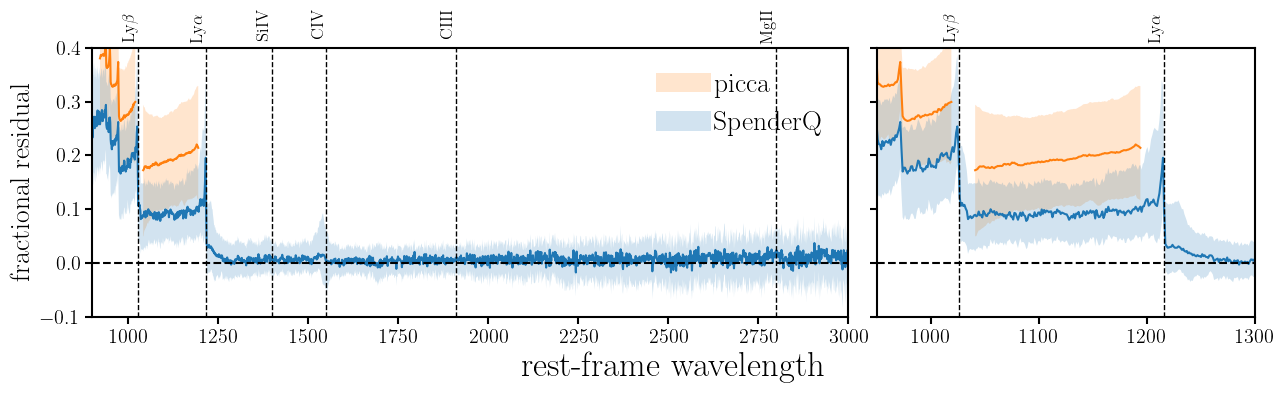

In [47]:
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# fractional residual
sub = plt.subplot(gs[0])

wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_q[:,1][wlim], dfcont_picca_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_q[:,2][wlim], color='C1')

sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle='--')
sub.axvline(1216, color='k', linewidth=1, linestyle='--')
sub.axvline(1397.61, color='k', linewidth=1, linestyle='--')
sub.axvline(1549.48, color='k', linewidth=1, linestyle='--')
sub.axvline(1908.73, color='k', linewidth=1, linestyle='--')
sub.axvline(2799.12, color='k', linewidth=1, linestyle='--')

sub.text(1026, 0.46, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.46, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1397.61, 0.47, r'SiIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1549.48, 0.47, r'CIV', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1908.73, 0.47, r'CIII', rotation=90., ha='right', va='top', fontsize=12)
sub.text(2799.12, 0.47, r'MgII', rotation=90., ha='right', va='top', fontsize=12)

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_ylabel('fractional residual', fontsize=20)
sub.set_ylim(-0.1, 0.4)

sub = plt.subplot(gs[1])

wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_q[:,2] > 0)

sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_q[:,1][wlim], dfcont_picca_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle='--')
sub.axvline(1216, color='k', linewidth=1, linestyle='--')
sub.text(1026, 0.46, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(1216, 0.46, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(950., 1300.)
sub.set_ylim(-0.1, 0.4)
sub.set_yticklabels([])
fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)

plt.savefig('spenderq_mock_recon_resid.pdf', bbox_inches='tight')

Text(0.5, 0, 'rest-frame wavelength')

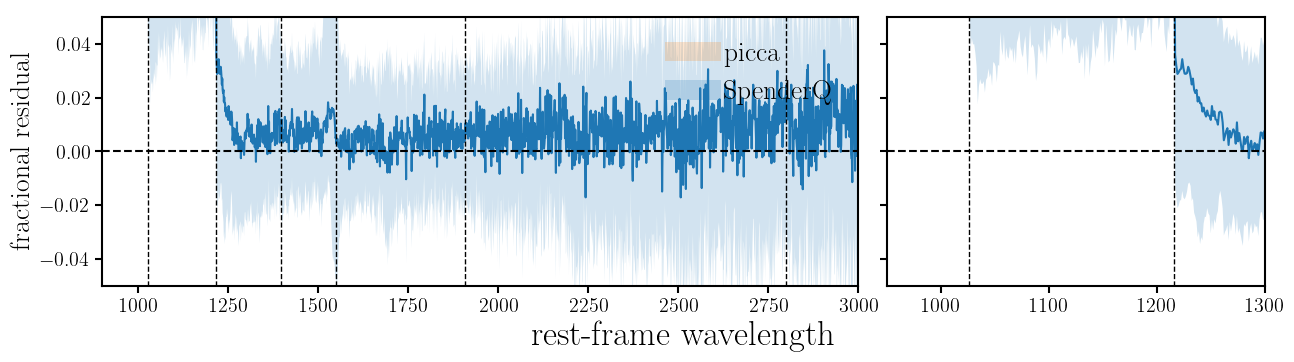

In [49]:
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[2, 1]) 

# fractional residual
sub = plt.subplot(gs[0])

wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_q[:,1][wlim], dfcont_picca_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_q[:,2][wlim], color='C1')

sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle='--')
sub.axvline(1216, color='k', linewidth=1, linestyle='--')
sub.axvline(1397.61, color='k', linewidth=1, linestyle='--')
sub.axvline(1549.48, color='k', linewidth=1, linestyle='--')
sub.axvline(1908.73, color='k', linewidth=1, linestyle='--')
sub.axvline(2799.12, color='k', linewidth=1, linestyle='--')

sub.legend(loc='upper right', handletextpad=0.1, fontsize=20)
sub.set_xlim(900., 3000.)
sub.set_ylabel('fractional residual', fontsize=20)
sub.set_ylim(-0.05, 0.05)

sub = plt.subplot(gs[1])

wlim = (dfcont_picca_lyb_q[:,2] > 0)
sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,1][wlim], dfcont_picca_lyb_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2, label='picca')
sub.plot(wave_rest_rebin[wlim], dfcont_picca_lyb_q[:,2][wlim], color='C1')

wlim = (dfcont_picca_q[:,2] > 0)

sub.fill_between(wave_rest_rebin[wlim], dfcont_picca_q[:,1][wlim], dfcont_picca_q[:,3][wlim], 
                 color='C1', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin[wlim], dfcont_picca_q[:,2][wlim], color='C1')

#sub.fill_between(wave_rest_rebin, dfcont_q[:,0], dfcont_q[:,4], color='C0', edgecolor='none', alpha=0.1)
sub.fill_between(wave_rest_rebin, dfcont_q[:,1], dfcont_q[:,3], color='C0', edgecolor='none', alpha=0.2)
sub.plot(wave_rest_rebin, dfcont_q[:,2], color='C0')
sub.axhline(0., color='k', linestyle='--')

sub.axvline(1026, color='k', linewidth=1, linestyle='--')
sub.axvline(1216, color='k', linewidth=1, linestyle='--')

sub.set_xlim(950., 1300.)
sub.set_ylim(-0.05, 0.05)
sub.set_yticklabels([])
fig.subplots_adjust(hspace=0.1, wspace=0.05)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)

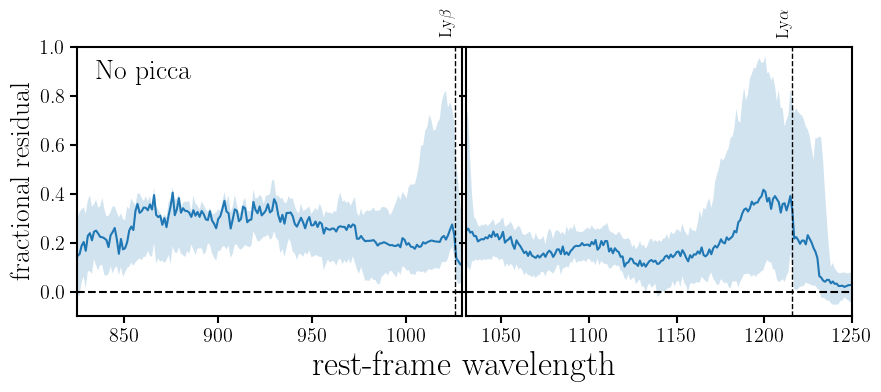

In [33]:
fig = plt.figure(figsize=(10,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1]) 

# fractional residual
sub = plt.subplot(gs[0])
sub.fill_between(wave_rest_rebin, dfcont_q_nopicca_lyb[:,1], dfcont_q_nopicca_lyb[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q_nopicca_lyb[:,2], color='C0')

sub.axhline(0., color='k', linestyle='--')
sub.axvline(1026, color='k', linewidth=1, linestyle='--')
sub.text(1026, 1.15, r'Ly$\beta$', rotation=90., ha='right', va='top', fontsize=12)
sub.text(0.05, 0.95, 'No picca', transform=sub.transAxes, ha='left', va='top', fontsize=20)

sub.set_xlim(825., 1030.)

sub.set_ylim(-0.1, 1.)
sub.set_ylabel('fractional residual', fontsize=20)

# fractional residual
sub = plt.subplot(gs[1])
sub.fill_between(wave_rest_rebin, dfcont_q_nopicca[:,1], dfcont_q_nopicca[:,3], 
                 color='C0', edgecolor='none', alpha=0.2, label='SpenderQ')
sub.plot(wave_rest_rebin, dfcont_q_nopicca[:,2], color='C0')

sub.axhline(0., color='k', linestyle='--')

sub.axvline(1216, color='k', linewidth=1, linestyle='--')
sub.text(1216, 1.15, r'Ly$\alpha$', rotation=90., ha='right', va='top', fontsize=12)

sub.set_xlim(1030., 1250.)
sub.set_xticks([1050, 1100, 1150, 1200, 1250])

sub.set_ylim(-0.1, 1.)
sub.set_yticklabels([])

fig.subplots_adjust(hspace=0.1, wspace=0.01)

sub = fig.add_subplot(111, frameon=False)
sub.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
sub.set_xlabel('rest-frame wavelength', fontsize=25)

plt.savefig('spenderq_mock_recon_resid_nopicca.pdf', bbox_inches='tight')